In [1]:
from transformers import CLIPProcessor, CLIPModel

# load pretrained model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
# load preprocessor for model input
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

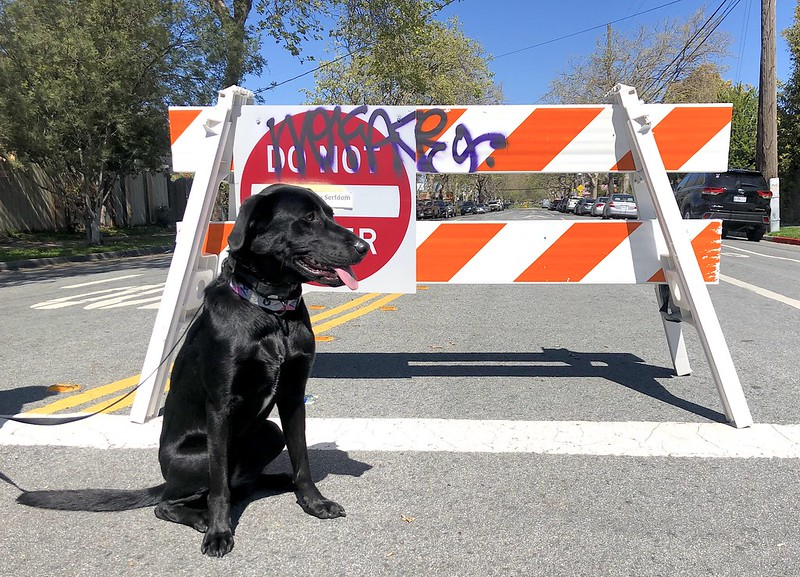

Predicted label: dog, probability score 0.9864757657051086


In [2]:
from PIL import Image

image = Image.open('../101-tensorflow-to-openvino/data/coco.jpg')
input_labels = ['cat', 'dog', 'wolf', 'tiger', 'man', 'horse', 'frog', 'tree', 'hause', 'computer']
text_descriptions = [f"This is a photo of a {label}" for label in input_labels]

inputs = processor(text=text_descriptions, images=image, return_tensors="pt", padding=True)

results = model(**inputs)
logits_per_image = results['logits_per_image'] # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

predicted_label = probs.argmax(dim=1).item()

display(image)
print(f'Predicted label: {input_labels[predicted_label]}, probability score {probs[0][predicted_label]}')


In [3]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'pixel_values'])

In [4]:
!python -m transformers.onnx -m openai/clip-vit-base-patch16 clip-vit-base-patch16

2023-01-02 14:36:50.821643: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Framework not requested. Using torch to export to ONNX.
Using framework PyTorch: 1.13.1+cpu
/home/ea/work/notebooks_env/lib/python3.8/site-packages/transformers/models/clip/modeling_clip.py:280: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
/home/ea/work/notebooks_env/lib/python3.8/site-packages/transformers/models/clip/modeling_clip.py:320: TracerWarning: Converting a tensor to a Python boolean might cause the tr

In [5]:
from openvino.runtime import serialize
from openvino.tools import mo

ov_model = mo.convert_model('clip-vit-base-patch32/model.onnx')
serialize(ov_model, 'clip-vit-base-patch32.xml')

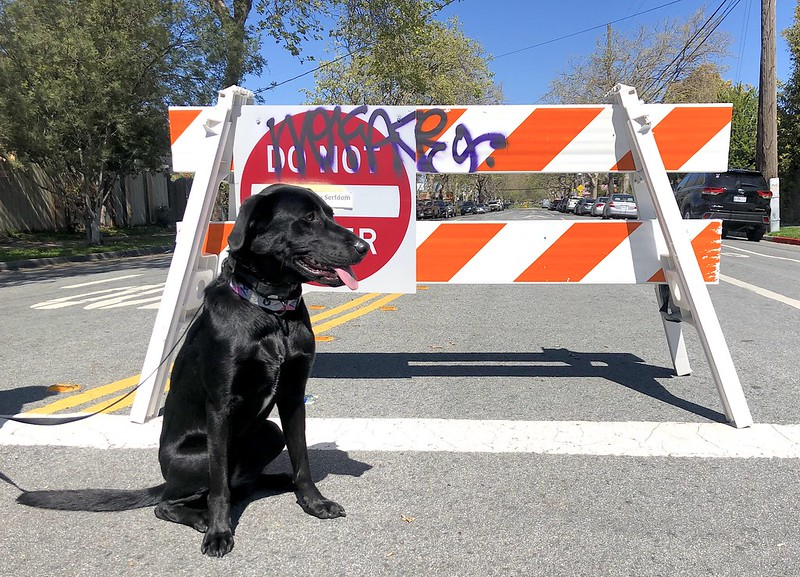

Predicted label: dog, probability score 0.9729190468788147


In [6]:
import numpy as np
from scipy.special import softmax
from openvino.runtime import Core

core = Core()
compiled_model = core.compile_model(ov_model)
logits_per_image_out = compiled_model.output(0)

ov_logits_per_image = compiled_model(dict(inputs))[logits_per_image_out]
probs = softmax(ov_logits_per_image, axis=1)
predicted_label = np.argmax(probs, axis=1)[0]
display(image)
print(f'Predicted label: {input_labels[predicted_label]}, probability score {probs[0][predicted_label]}')

In [7]:
from torchvision.datasets import OxfordIIITPet
dataset = OxfordIIITPet("data", split="test", download=True)
labels = dataset.classes
text_descriptions = [f"This is a photo of a {label}" for label in labels]
labels_encoded = dict(processor(text_descriptions, return_tensors='np', padding=True))

In [17]:
class DataLoader:
    def __init__(self, encoded_labels, images_dataset, preprocesor, num_samples=100):
        self.encoded_labels = encoded_labels
        self.images_dataset = images_dataset
        self.preprocessor = preprocesor
        self.num_samples = num_samples
        self.classes = self.images_dataset.classes
    
    def orig_image(self, i):
        return self.images_dataset[i][0]

    def __getitem__(self, i):
        if self.num_samples is not None and i > self.num_samples:
            raise StopIteration
        image, label = self.images_dataset[i]
        data_batch = dict(self.preprocessor(images=[image], return_tensors='np'))
        data_batch.update(self.encoded_labels)
        return data_batch, label

    def __len__(self):
        return len(self.images_dataset) if self.num_samples is None else min(self.num_samples, len(self.images_dataset))

In [18]:
clip_dataset = DataLoader(labels_encoded, dataset, processor)

In [19]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
from tqdm.notebook import tqdm
samples = np.random.choice(50, 8)
def test_on_images(model, dataset, samples=samples):
    plt.figure(figsize=(16, 16))
    output_layer = model.output(0)
    
    for i, idx in tqdm(enumerate(samples)):
        input_dict, _ = dataset[samples[i]]
        image = dataset.orig_image(samples[i])
        logits = model(input_dict)[output_layer][0]
        probs = softmax(logits)
        top_5 = np.argsort(-probs)[:5]
        top_probs = probs[top_5]
        plt.subplot(4, 4, 2 * i + 1)
        plt.imshow(image)
        plt.axis("off")

        plt.subplot(4, 4, 2 * i + 2)
        y = np.arange(top_probs.shape[-1])
        plt.grid()
        plt.barh(y, top_probs)
        plt.gca().invert_yaxis()
        plt.gca().set_axisbelow(True)
        plt.yticks(y, [labels[index] for index in top_5])
        plt.xlabel("probability")

    plt.subplots_adjust(wspace=0.5)
    plt.show()

0it [00:00, ?it/s]

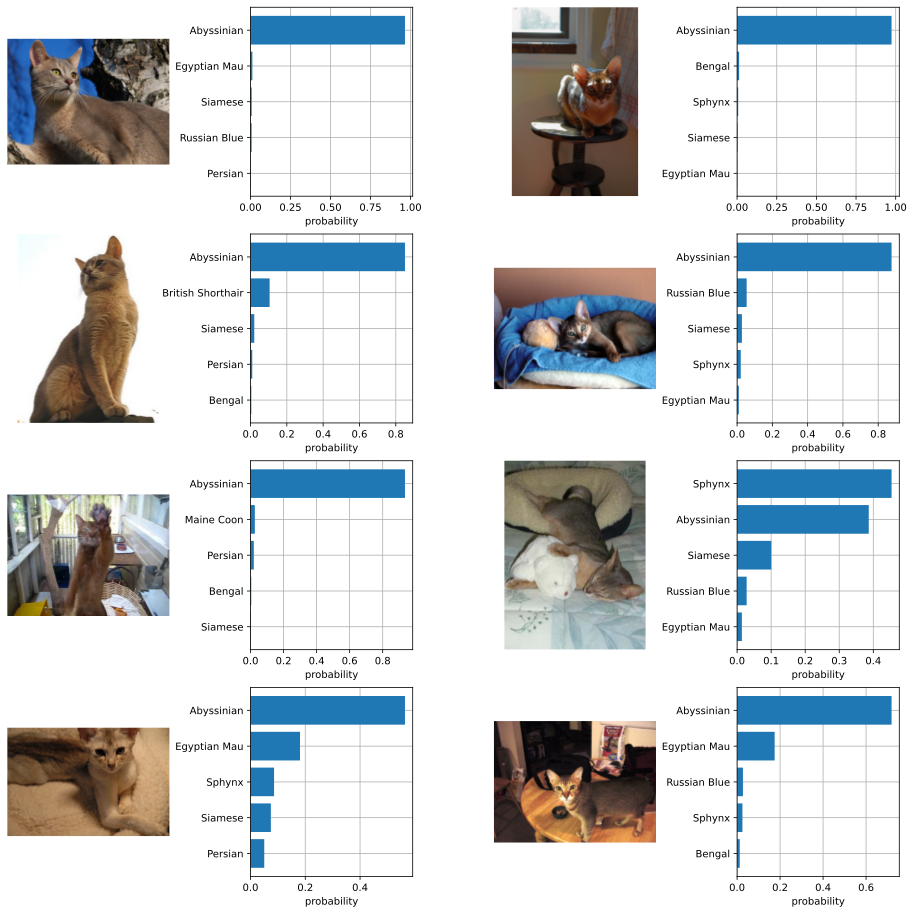

In [20]:
test_on_images(compiled_model, clip_dataset)

In [21]:
from tqdm.notebook import tqdm


def validate_model(model, val_dataset):
    top1, top5 = 0, 0
    output_layer = model.output(0)
    num_samples = 0
    for input_data, label in val_dataset:
        num_samples += 1
        scores = model(input_data)[output_layer][0]
        top5_labels = np.argsort(-scores)[:5]
        top5 += int(label in top5_labels)
        top1 += int(label == top5_labels[0])
    return top1 / num_samples

In [22]:
top1_acc = validate_model(compiled_model, clip_dataset)
print(f'Accuracy Top-1 {top1_acc * 100} %')
#print(f'Accuracy Top-5 {top5_acc * 100} %')

Accuracy Top-1 87.12871287128714 %


In [23]:
import nncf

def transform_fn(data_item):
    """
    Quantization transform function. Extracts and preprocess input data from dataloader item for quantization.
    Parameters:
       data_item: Tuple with data item produced by DataLoader during iteration
    Returns:
        input_tensor: Input data for quantization
    """
    #return [data_item[0]]
    return data_item[0]


quantization_dataset = nncf.Dataset(clip_dataset, transform_fn)

In [25]:
quantized_model = nncf.quantize(
    ov_model,
    quantization_dataset,
    model_type=nncf.parameters.ModelType.TRANSFORMER,
    subset_size=10,
)

serialize(quantized_model, "clip-vit-base-patch16-int8.xml")

INFO:openvino.tools.pot.pipeline.pipeline:Inference Engine version:                2023.0.0-9197-b111e90635d
INFO:openvino.tools.pot.pipeline.pipeline:Model Optimizer version:                 2023.0.0-9197-b111e90635d
INFO:openvino.tools.pot.pipeline.pipeline:Post-Training Optimization Tool version: 2023.0.0-9197-b111e90635d
INFO:openvino.tools.pot.statistics.collector:Start computing statistics for algorithms : DefaultQuantization
INFO:openvino.tools.pot.statistics.collector:Computing statistics finished
INFO:openvino.tools.pot.pipeline.pipeline:Start algorithm: DefaultQuantization
INFO:openvino.tools.pot.algorithms.quantization.default.algorithm:Start computing statistics for algorithm : ActivationChannelAlignment
INFO:openvino.tools.pot.algorithms.quantization.default.algorithm:Computing statistics finished
INFO:openvino.tools.pot.algorithms.quantization.default.algorithm:Start computing statistics for algorithms : MinMaxQuantization,FastBiasCorrection


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ <ipython-input-25-b3b8b9621729>:1 in <module>                                                    │
│                                                                                                  │
│ /home/ea/work/notebooks_env/lib/python3.8/site-packages/nncf/quantization/quantize.py:65 in      │
│ quantize                                                                                         │
│                                                                                                  │
│    62 │   backend = get_backend(model)                                                           │
│    63 │   if backend == BackendType.OPENVINO:                                                    │
│    64 │   │   from nncf.openvino.quantization.quantize import quantize_impl                      │
│ ❱  65 │   │   return quantize_impl(model, calibration_dataset, preset, target_device, subset_s   │
│    66 │   │   │   │   │   │   │    fast_bias_correction, model_type, ignored_scope)              │
│    67 │                                                                                          │
│    68 │   if backend == BackendType.ONNX:                                                        │
│                                                                                                  │
│ /home/ea/work/notebooks_env/lib/python3.8/site-packages/nncf/telemetry/decorator.py:70 in        │
│ wrapped                                                                                          │
│                                                                                                  │
│   67 │   │   │   │   │   │   │   │   │   │   │   │    event_label=event.data,                    │
│   68 │   │   │   │   │   │   │   │   │   │   │   │    event_value=event.int_data)                │
│   69 │   │   │   │                                                                               │
│ ❱ 70 │   │   │   │   retval = fn(*args, **kwargs)                                                │
│   71 │   │   │   │                                                                               │
│   72 │   │   │   │   if category is not None and category != previous_category:                  │
│   73 │   │   │   │   │   NNCFTelemetry.end_session(self._category)                               │
│                                                                                                  │
│ /home/ea/work/notebooks_env/lib/python3.8/site-packages/nncf/openvino/quantization/quantize.py:1 │
│ 40 in quantize_impl                                                                              │
│                                                                                                  │
│   137 │                                                                                          │
│   138 │   engine = OVEngine(engine_config, calibration_dataset, calibration_dataset)             │
│   139 │   pipeline = pot.create_pipeline(algorithms, engine)                                     │
│ ❱ 140 │   compressed_model = pipeline.run(pot_model)                                             │
│   141 │   pot.compress_model_weights(compressed_model)                                           │
│   142 │   quantized_model = _convert_compressed_model_to_openvino_model(compressed_model)        │
│   143 │   return quantized_model                                                                 │
│                                                                                                  │
│ /home/ea/work/notebooks_env/lib/python3.8/site-packages/openvino/tools/pot/pipeline/pipeline.py: │
│ 52 in run                                                                                        │
│                                                                                                  │
│    49 │   │   │   │   model = self.collect_statistics_and_r

In [24]:
quantized_model = nncf.quantize_with_accuracy_control(
    ov_model,
    quantization_dataset,
    nncf.Dataset(clip_dataset),
    validate_model,
    model_type=nncf.parameters.ModelType.TRANSFORMER,
    subset_size=10,
)

serialize(quantized_model, "clip-vit-base-patch16-int8.xml")

INFO:openvino.tools.pot.pipeline.pipeline:Inference Engine version:                2023.0.0-9197-b111e90635d
INFO:openvino.tools.pot.pipeline.pipeline:Model Optimizer version:                 2023.0.0-9197-b111e90635d
INFO:openvino.tools.pot.pipeline.pipeline:Post-Training Optimization Tool version: 2023.0.0-9197-b111e90635d
INFO:openvino.tools.pot.statistics.collector:Start computing statistics for algorithms : AccuracyAwareCommon
INFO:openvino.tools.pot.statistics.collector:Computing statistics finished
INFO:openvino.tools.pot.pipeline.pipeline:Start algorithm: AccuracyAwareCommon
INFO:openvino.tools.pot.algorithms.quantization.accuracy_aware_common.algorithm:Start original model inference
INFO:openvino.tools.pot.algorithms.quantization.accuracy_aware_common.algorithm:Baseline metrics: {'original_metric': 0.8712871287128713}
INFO:openvino.tools.pot.algorithms.quantization.accuracy_aware_common.algorithm:Start quantization
INFO:openvino.tools.pot.algorithms.quantization.default.algori

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ <ipython-input-24-cb5d6fa1eb3b>:1 in <module>                                                    │
│                                                                                                  │
│ /home/ea/work/notebooks_env/lib/python3.8/site-packages/nncf/quantization/quantize.py:129 in     │
│ quantize_with_accuracy_control                                                                   │
│                                                                                                  │
│   126 │   backend = get_backend(model)                                                           │
│   127 │   if backend == BackendType.OPENVINO:                                                    │
│   128 │   │   from nncf.openvino.quantization.quantize import quantize_with_accuracy_control_i   │
│ ❱ 129 │   │   return quantize_with_accuracy_control_impl(model, calibration_dataset, validatio   │
│   130 │   │   │   │   │   │   │   │   │   │   │   │      max_drop, preset, target_device, subs   │
│   131 │   │   │   │   │   │   │   │   │   │   │   │      fast_bias_correction, model_type, ign   │
│   132                                                                                            │
│                                                                                                  │
│ /home/ea/work/notebooks_env/lib/python3.8/site-packages/nncf/openvino/quantization/quantize.py:2 │
│ 03 in quantize_with_accuracy_control_impl                                                        │
│                                                                                                  │
│   200 │                                                                                          │
│   201 │   engine = OVEngine(engine_config, calibration_dataset, validation_dataset, validation   │
│   202 │   pipeline = pot.create_pipeline(algorithms, engine)                                     │
│ ❱ 203 │   compressed_model = pipeline.run(pot_model)                                             │
│   204 │   pot.compress_model_weights(compressed_model)                                           │
│   205 │                                                                                          │
│   206 │   quantized_model = _convert_compressed_model_to_openvino_model(compressed_model)        │
│                                                                                                  │
│ /home/ea/work/notebooks_env/lib/python3.8/site-packages/openvino/tools/pot/pipeline/pipeline.py: │
│ 49 in run                                                                                        │
│                                                                                                  │
│    46 │   │   │   current_algo_seq.append(algo)                                                  │
│    47 │   │   │                                                                                  │
│    48 │   │   │   if algo.change_original_model:                                                 │
│ ❱  49 │   │   │   │   model = self.collect_statistics_and_run(model, current_algo_seq)           │
│    50 │   │   │   │   current_algo_seq = []                                                      │
│    51 │   │                                                                                      │
│    52 │   │   result = self.collect_statistics_and_run(model, current_algo_seq)                  │
│                                                                                                  │
│ /home/ea/work/notebooks_env/lib/python3.8/site-packages/openvino/tools/pot/pipeline/pipeline.py: │
│ 62 in collect_statistics_and_run                                                                 │
│                                                                                                  │
│    59 │   │                                                

In [ ]:
compiled_model_int8 = core.compile_model(quantized_model)
test_on_images(compiled_model_int8, clip_dataset)

In [ ]:
top1_acc = validate_model(compiled_model_int8, clip_dataset)
print(f'Accuracy Top-1 {top1_acc * 100} %')